# HW2 - Type 1 Diabetes Detection

### In this assignment, we will do the following:
* Explore the data provided.
* Implement linear and non-linear classifiers.
* Model optimization with k-fold cross validation
* Evaluate your model performances with appropriate metrics.
* Present a 2d visualization of multi-featured data.
*Use feature selection tools.

#### Data Loading and Exploration

In [1]:
path = '.\HW2_data.csv'

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d
from matplotlib import cm

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
warnings.filterwarnings('ignore')
mpl.style.use(['ggplot']) 

In [3]:
dataset = pd.read_csv(path)
dataset.head()

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0


In [4]:
dataset = dataset.replace('No', 0).replace('Yes', 1).replace('Positive', 1).replace('Negative', 0)

<AxesSubplot:ylabel='Diagnosis'>

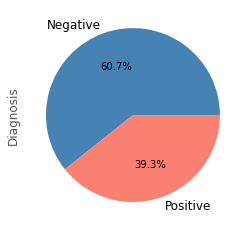

In [5]:
Y = dataset.iloc[:, -2]
Y.value_counts().plot(kind='pie', labels=['Negative', 'Positive'], colors=['steelblue', 'salmon'], autopct='%1.1f%%')

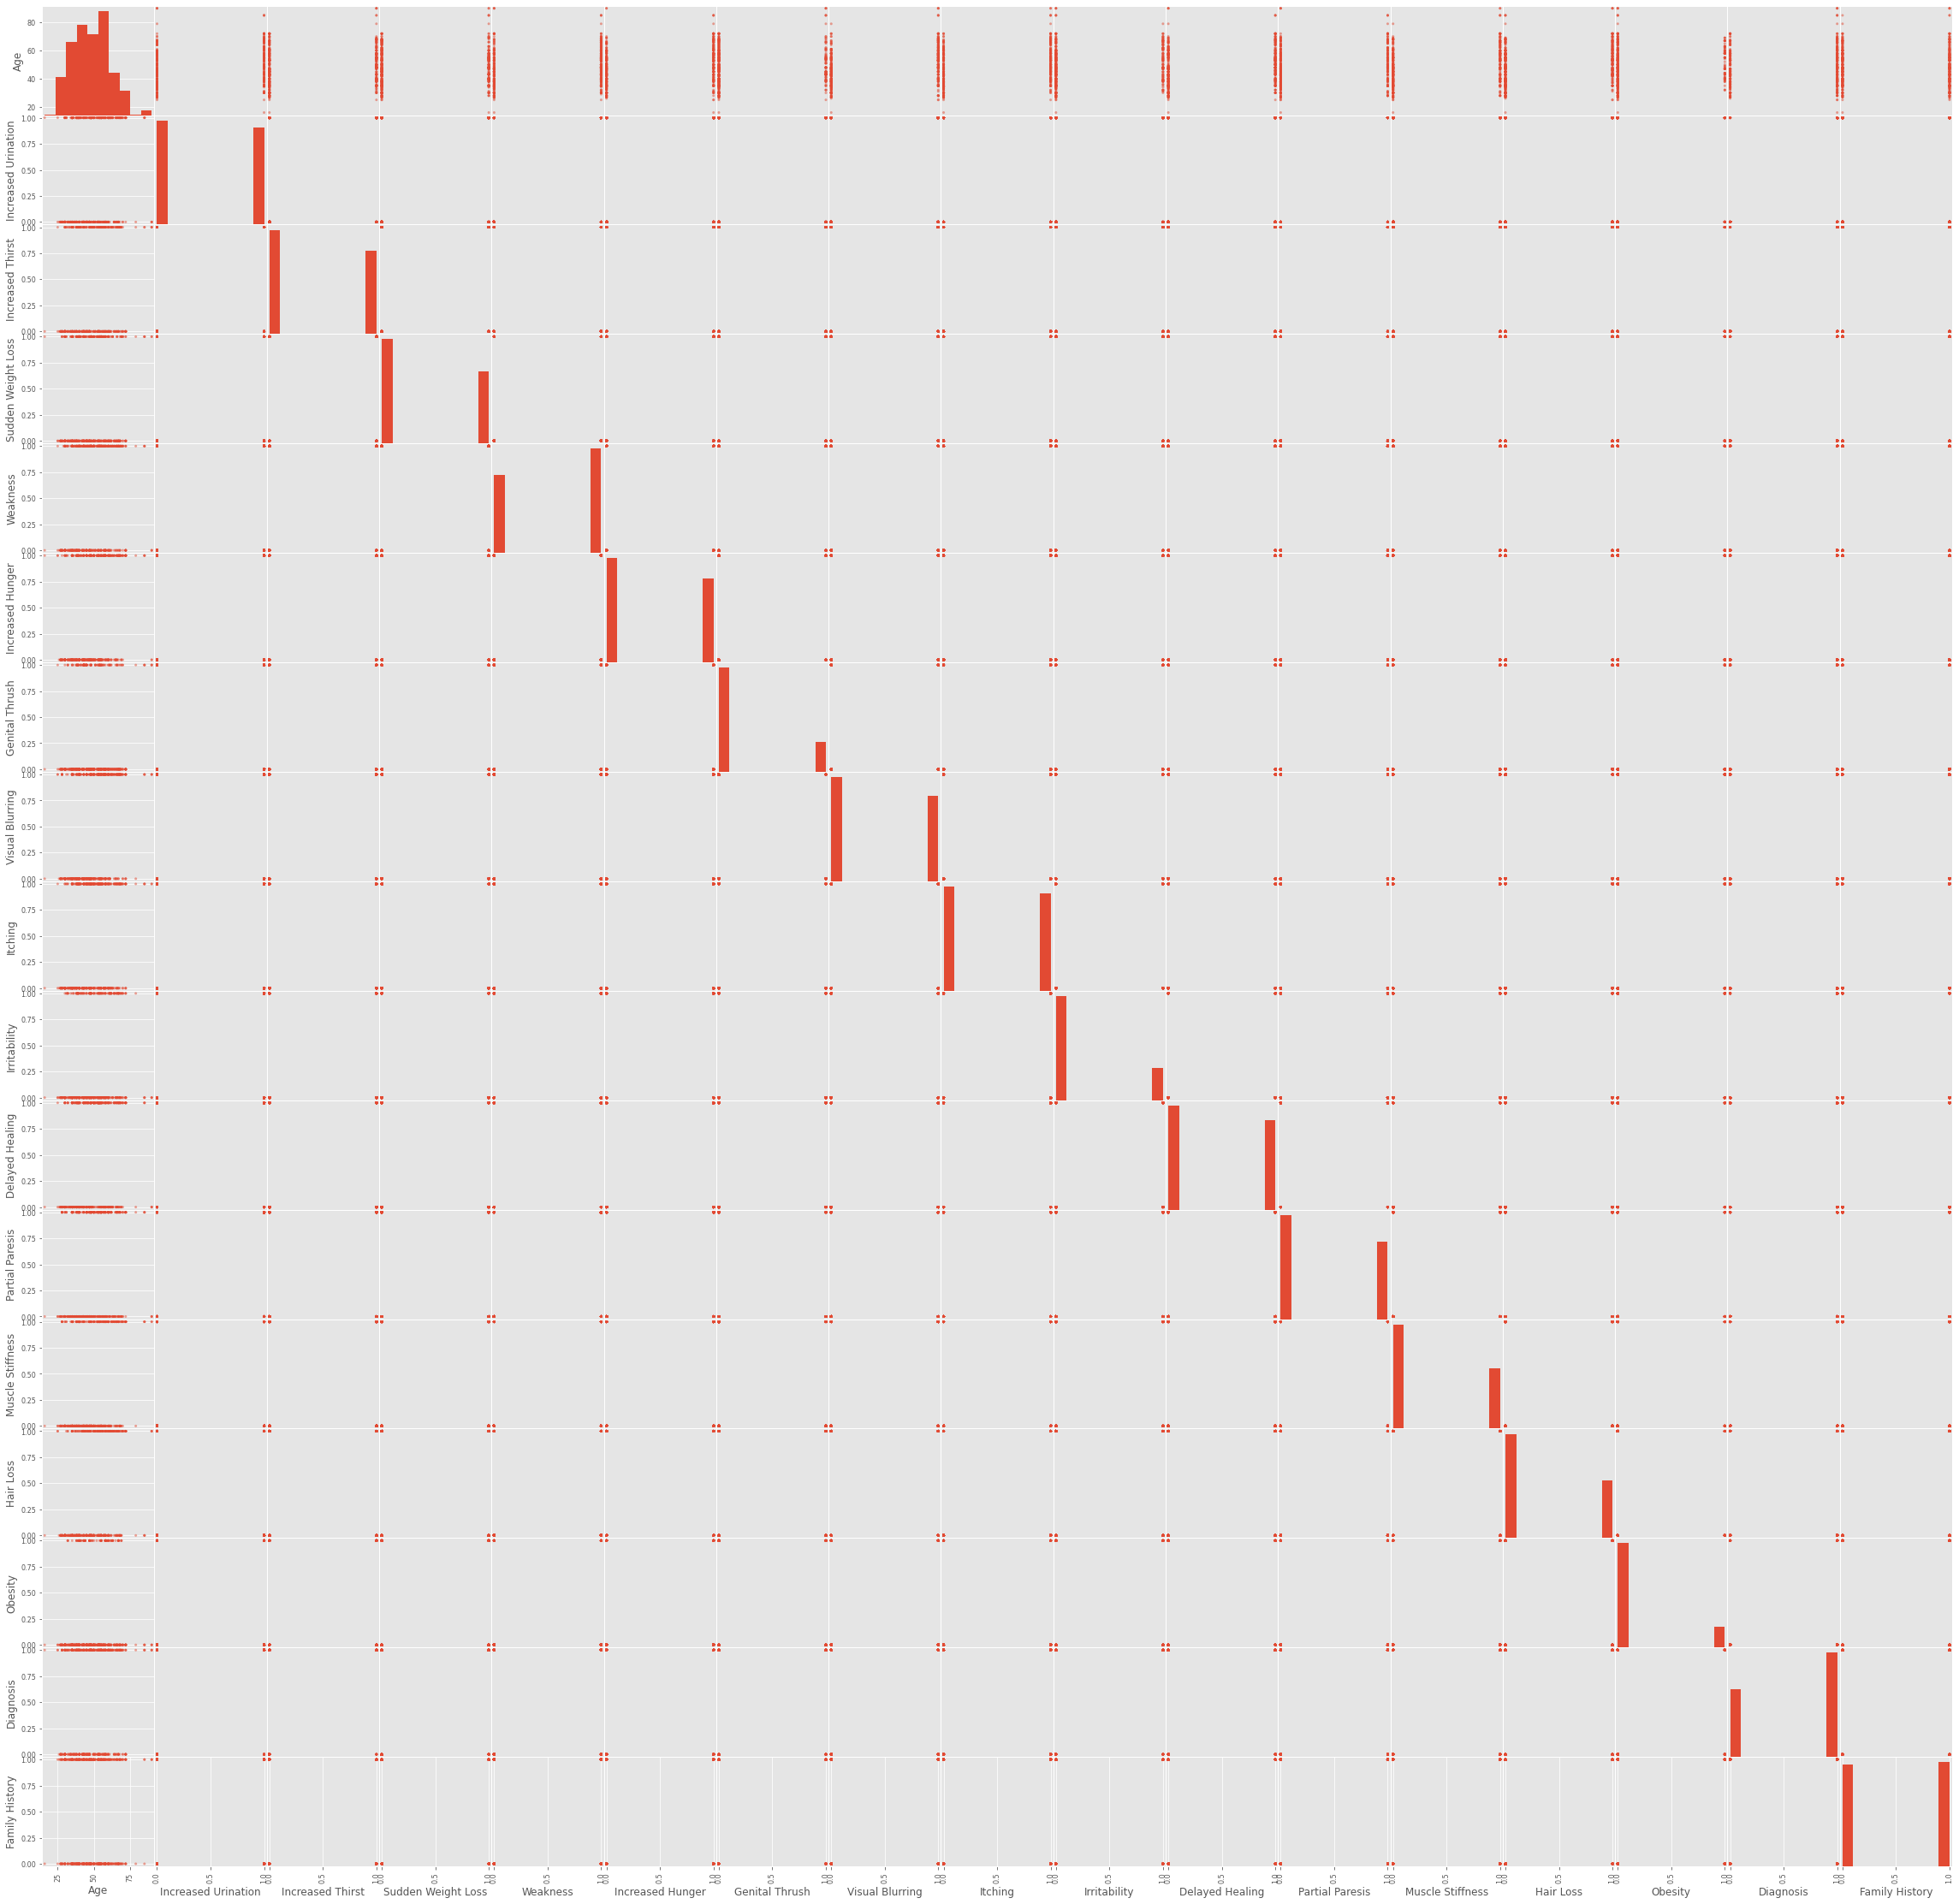

In [11]:
pd.plotting.scatter_matrix(dataset, figsize=(40, 40))
plt.show()

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Increased Urination'}>,
        <AxesSubplot:title={'center':'Increased Thirst'}>,
        <AxesSubplot:title={'center':'Sudden Weight Loss'}>],
       [<AxesSubplot:title={'center':'Weakness'}>,
        <AxesSubplot:title={'center':'Increased Hunger'}>,
        <AxesSubplot:title={'center':'Genital Thrush'}>,
        <AxesSubplot:title={'center':'Visual Blurring'}>],
       [<AxesSubplot:title={'center':'Itching'}>,
        <AxesSubplot:title={'center':'Irritability'}>,
        <AxesSubplot:title={'center':'Delayed Healing'}>,
        <AxesSubplot:title={'center':'Partial Paresis'}>],
       [<AxesSubplot:title={'center':'Muscle Stiffness'}>,
        <AxesSubplot:title={'center':'Hair Loss'}>,
        <AxesSubplot:title={'center':'Obesity'}>,
        <AxesSubplot:title={'center':'Diagnosis'}>],
       [<AxesSubplot:title={'center':'Family History'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot

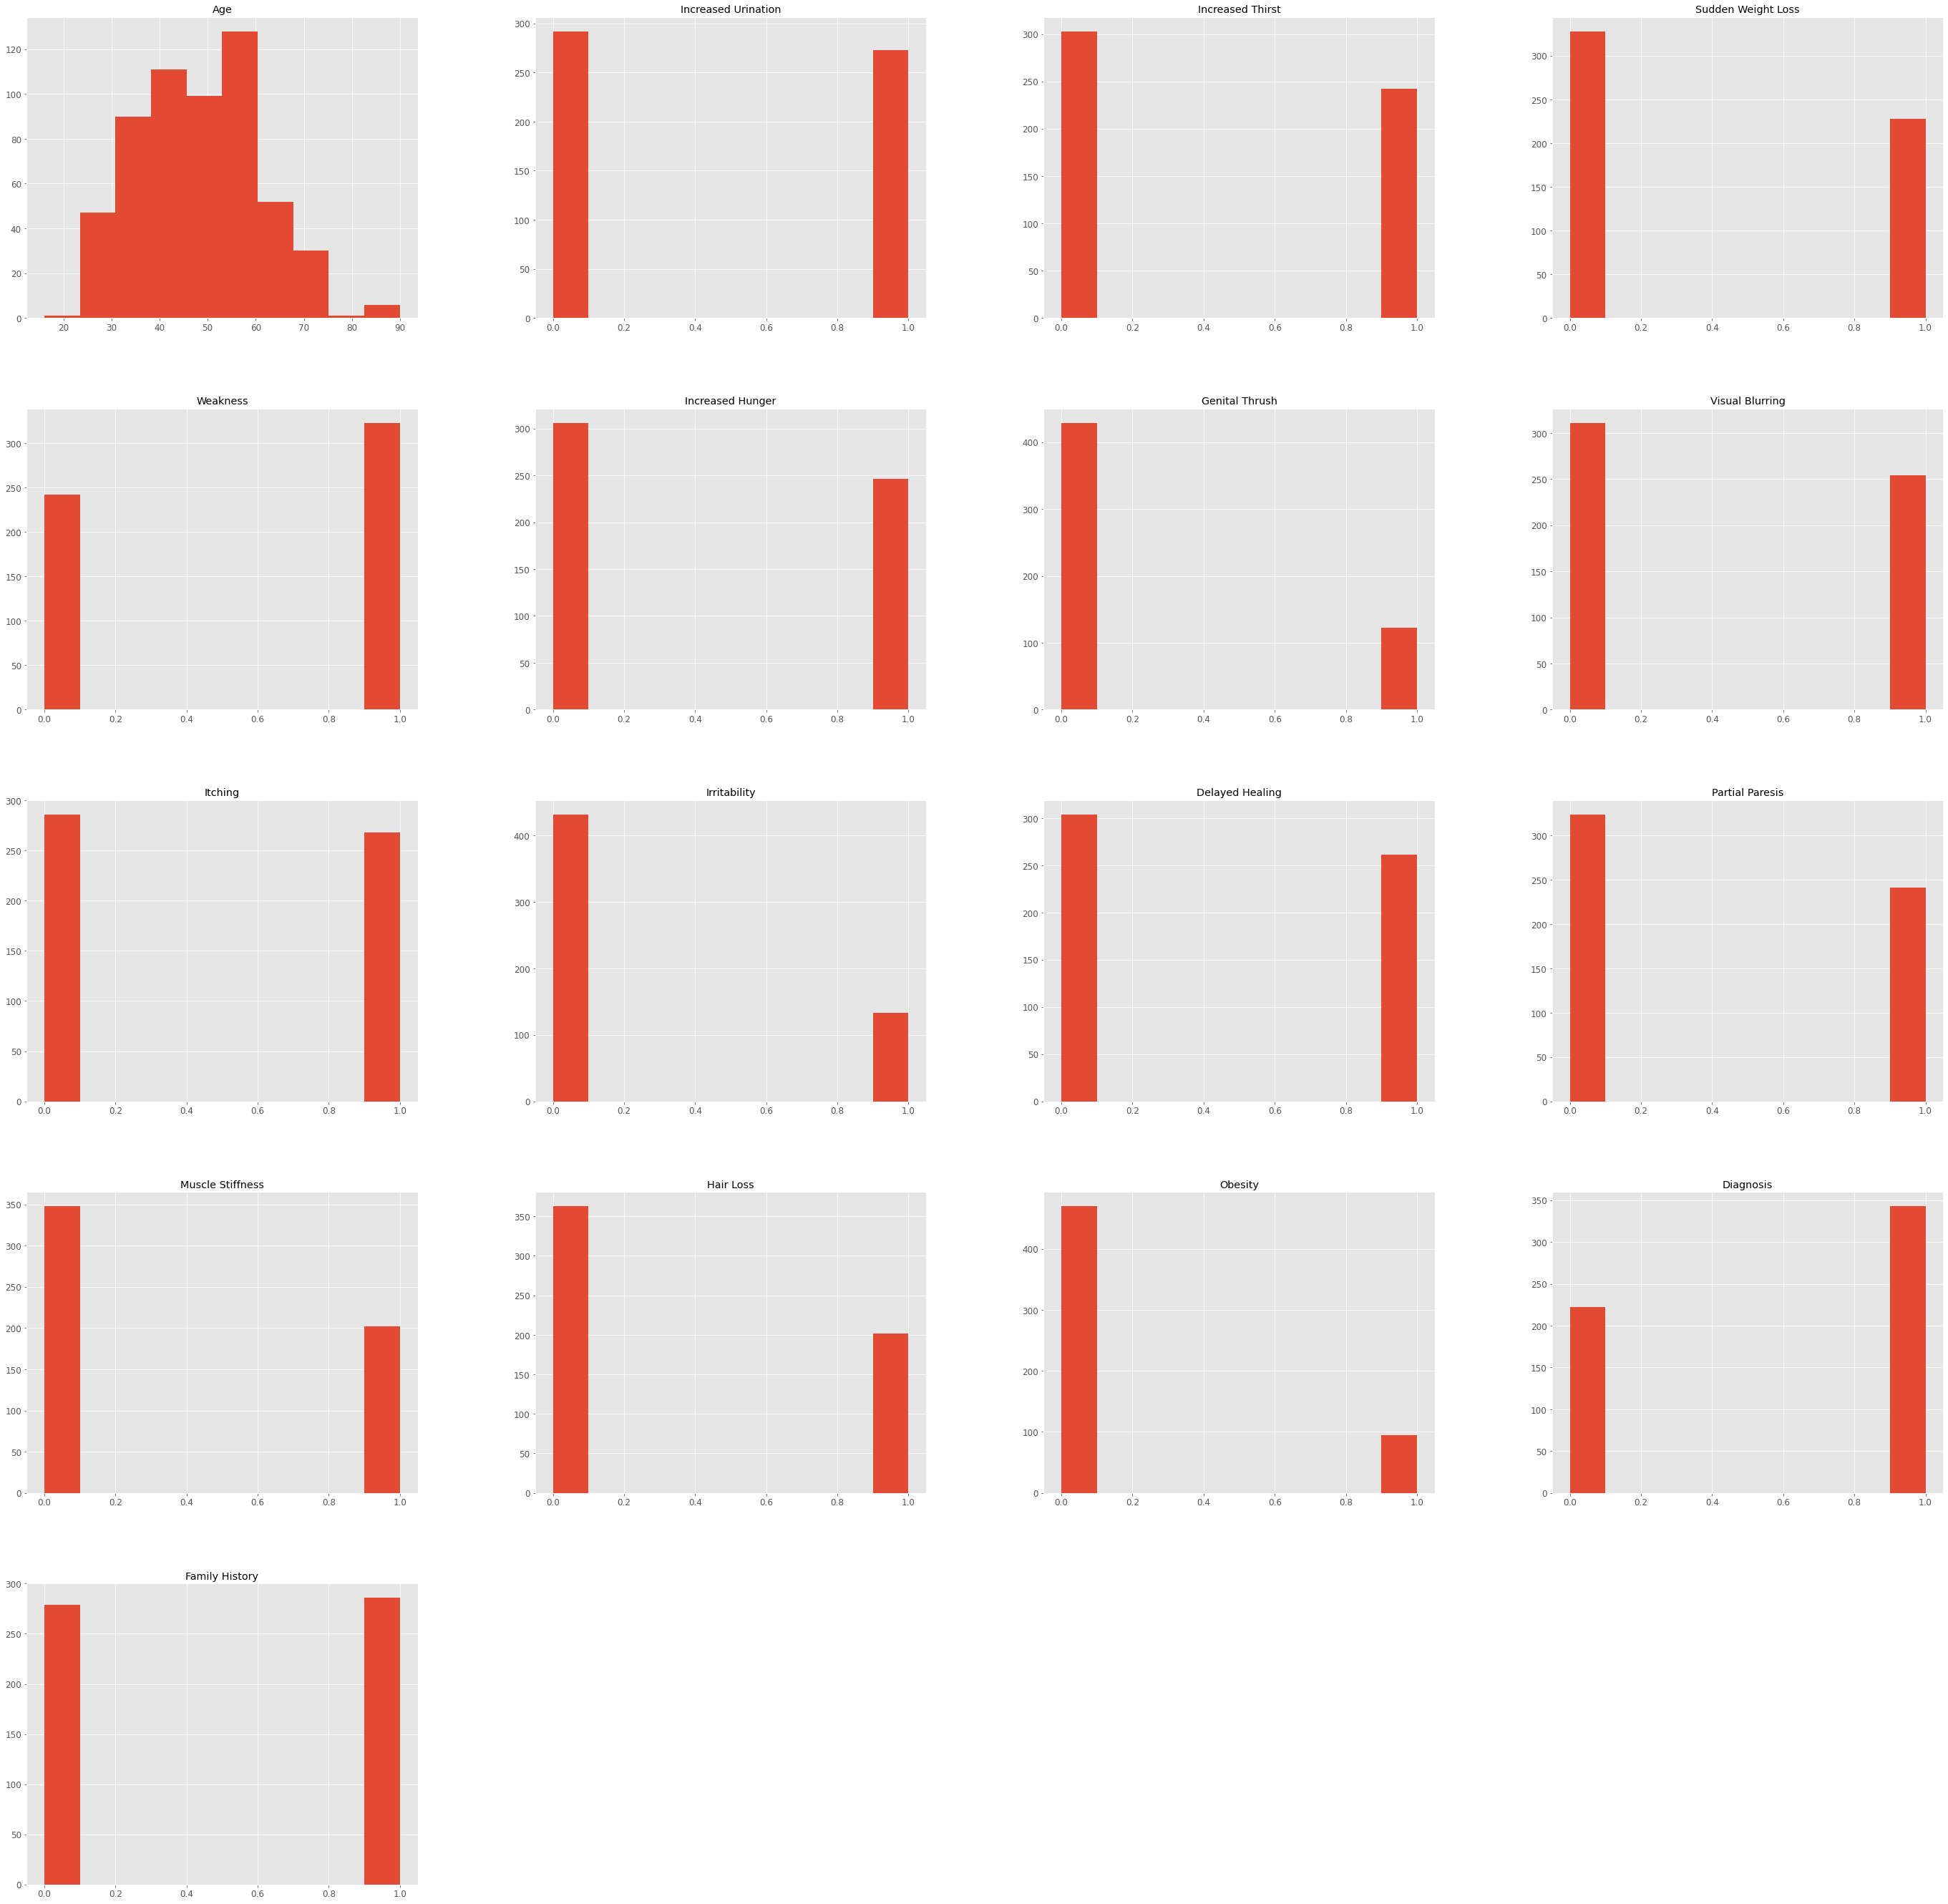

In [12]:
dataset.hist(figsize=(48, 48))

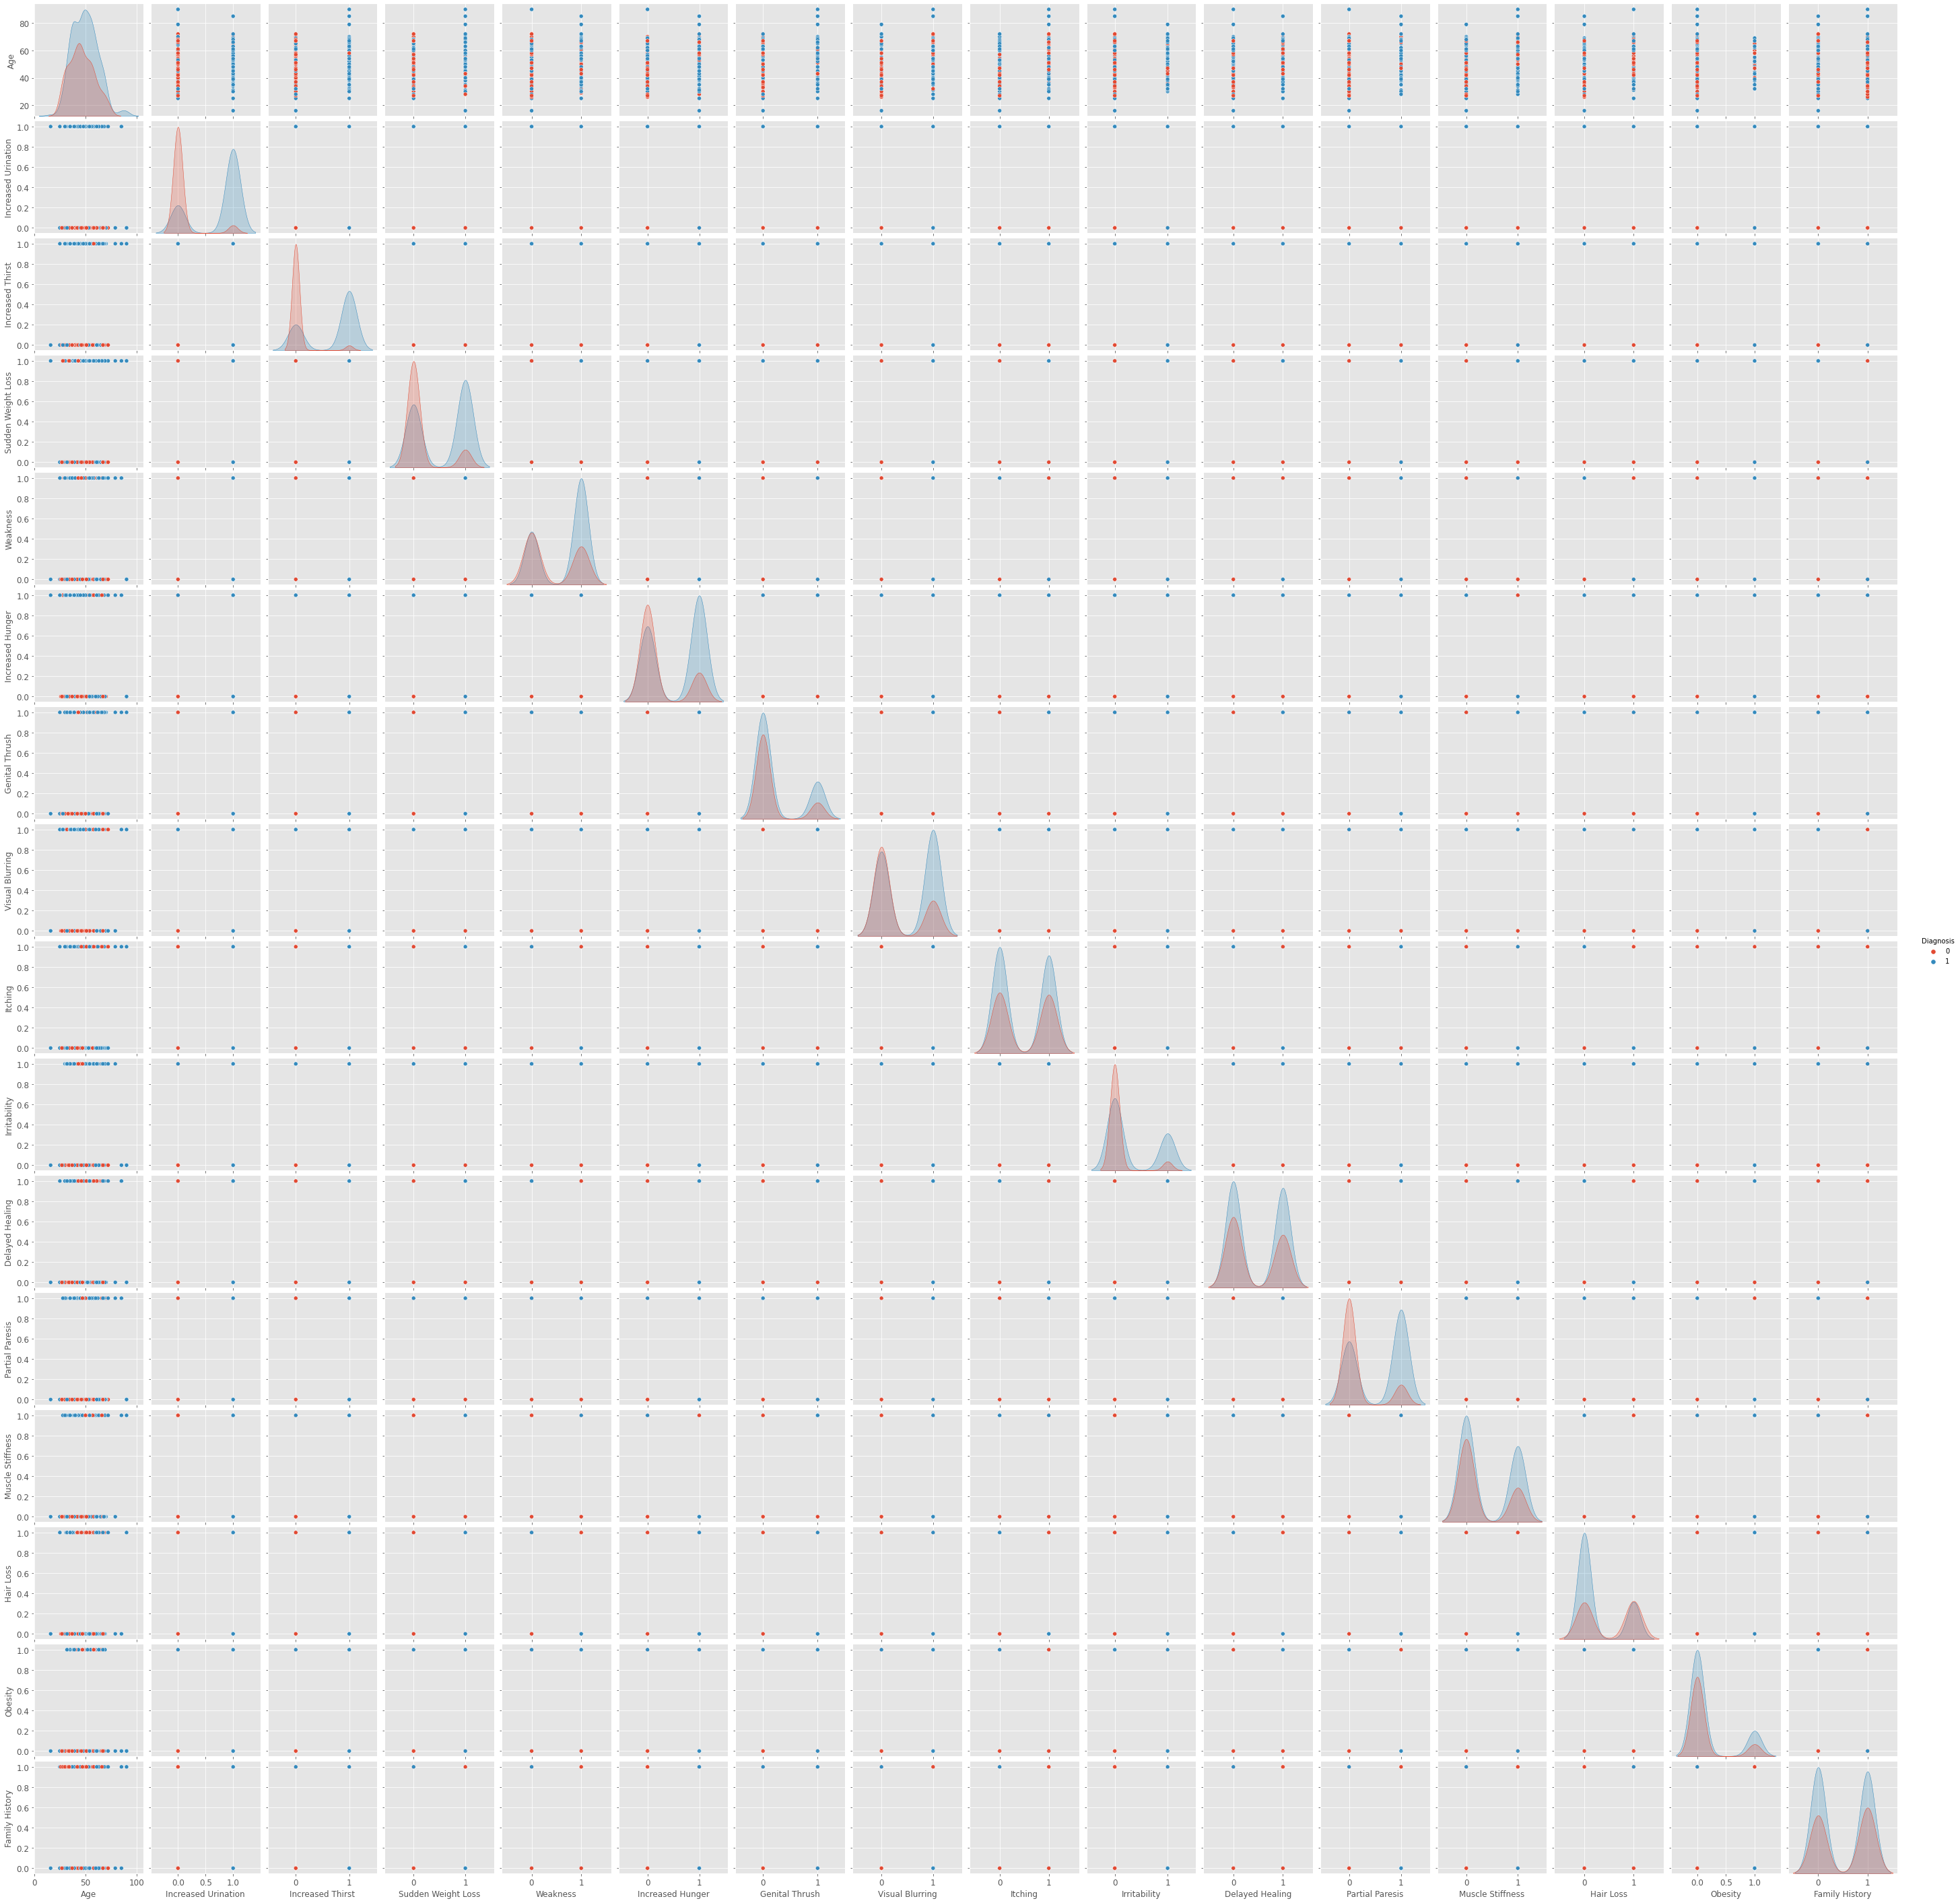

In [8]:
sns.pairplot(dataset.loc[:,:], hue="Diagnosis")

In [9]:
data_scaled = (X - X.mean()) / (X.std())  

NameError: name 'X' is not defined